In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime

# IMAGE IMPORTS
from PIL import Image

# GIS IMPORTS
from affine import Affine
import pandas as pd

# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")

IO directories depending on which machine. 

In [2]:
username = os.getlogin()

if username == 'fhacesga':
    base_input_path   = r"D:\FloodChange\AAA_HistoricalDownload"
    base_output_path  = r"C:\Users\\"+username+"\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
elif username == 'fhace':
    ref_dir = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

init_databases(ref_dir)

Create working dir and unzip all files if needed

In [3]:
proc_dir = None
proc_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\"

if proc_dir is None:
    datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    proc_dir     = os.path.join(base_output_path, datetime_str)
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    print(proc_dir)
    os.makedirs(proc_dir)
    os.makedirs(unzipped_dir)
    os.makedirs(outputs_dir)
    extractZipFiles(base_input_path, unzipped_dir)
else:
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    rmtree(outputs_dir)
    os.makedirs(outputs_dir)

Read through all the images in the directory. Some images are saved as Multi-page TIFF files. These need to be exported into individual images. We'll do that first

In [ ]:
for filename in tqdm(glob.glob(unzipped_dir + "\\*.tif*")):
    tiff_file = os.path.join(unzipped_dir, filename)
    try:
    # Check if the file is a multi-page TIFF
        with Image.open(tiff_file) as img:
            if img.is_animated:    
                for i in range(img.n_frames):
                    try:
                        img.seek(i)
                        output_filename = f"{os.path.splitext(tiff_file)[0]}_{i+1}{os.path.splitext(tiff_file)[1]}"
                        img.save(output_filename, format=img.format)
                    except:
                        print(f"Error with {tiff_file} page {i}")
                        continue
    except:
        print(f"Error opening {tiff_file}")
        continue

    os.remove(tiff_file)

Here we're using heuristics to identify indices within all the image files. These include:
- Files that are shorter than 12 characters
- Files that have the ```IND``` marker

We create a Pandas DataFrame with the files matching. We then add several fields as below

In [4]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{unzipped_dir}/*")

# FILTER IMAGES USING HEURISTICS
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(unzipped_dir + "\\*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# CREATE DATAFRAME
index_files = pd.DataFrame(index_files, columns=["FilePath"])

# INDEX ATTRIBUTES TO BE ADDED
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]    # BASENAME
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)   # 
index_files["GEOID"]    = index_files["Location"].apply(getGEOID)       # GET GEOID FOR EACH INDEX
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)       # GET GEOMETRY FROM MATCHING GEOIDs

C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480233IND0_0382.jpg


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\Inputs\480233IND0_0382.jpg: 1024x1024 4 tiles, 1 county, 939.0ms
Speed: 12.0ms preprocess, 939.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


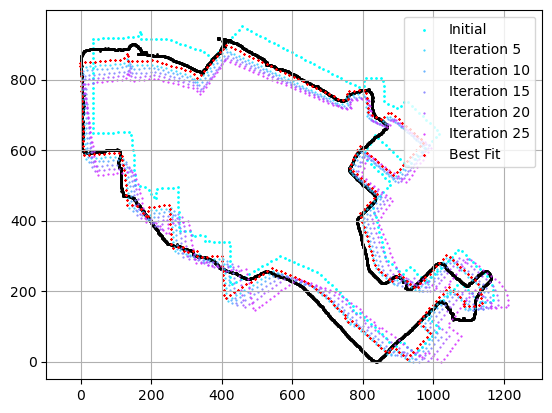

NameError: name 'error' is not defined

In [5]:
verbose = True

TPNN = None
RLNN = None
CLNN = None
TLNN = None

for i, row in index_files.iterrows():
    print(row["FilePath"])
    
    filename = os.path.basename(row["FilePath"])
    
    # READ FILES AND CONVERT TO GRAYSCALE
    image = cv2.imread(row["FilePath"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_arry = np.asarray(image)
    
    # SAVE IMAGE TO OUTPUT DIRECTORY
    output_image_fn = os.path.join(outputs_dir, filename)
    copyfile(row["FilePath"], output_image_fn)
    
    # RUN IMAGES THROUGH DNNs
    classifications, TPNN  = findKeypoints(image, model=TPNN)
    effectiveArea, RLNN    = findSquares(image, model=RLNN)
    countyArea, CLNN       = findCounty(image, model=CLNN)
    tiles, TLNN            = findTiles(row["FilePath"], model=TLNN)

    dnn_outputs = {
        "classifications"   : classifications,
        "effectiveArea"     : effectiveArea,
        "countyArea"    : countyArea,
        "tiles"         : tiles
    }

    # GET BOUNDARY POINTS FROM RESPECTIVE SHAPEFILE
    point_boundary_gdf, shp_bounds = getBoundaryPoints(row, distance=100)
    
    # GET COUNTY BOUNDS IDENTIFIED IN INDEX BY TLNN
    bounds_panels = tiles["county"]["bbox"]

    # SKIP IF WE CAN'T FIND BOUNDARY IN EXISTING DATABASES
    if point_boundary_gdf is None:
        continue

    # DEFINE BOUNDARY STRUCTU
    boundaries = {
        "point_boundary_gdf"    : point_boundary_gdf,
        "shp_bounds"            : shp_bounds,
        "bounds_panels"         : bounds_panels,
    }

    # WHAT ARE WE LOOKING FOR IN EACH IDENTIFIED SQUARE?
    key = findKey(row["Basename"])    
    if key is None:
        print(f"Could not find key in {filename}")
    
    # DO ICP
    transform_dict = performICPonIndex(boundaries, dnn_outputs, debug=False, plot=True, icp_iterations=30)

    # GET TRANSFORM FROM ICP TO CRS TRANSFORM
    output_transform, _ = ICPtoCRSTransform(image_arry, transform_dict)

    # GET OUTPUT TRANSFORM INTO AFFINE AND WRITE
    output_affine = Affine(*output_transform.flatten()[:6])
    write_world_file_from_affine(output_affine, get_world_file_path(output_image_fn))
    error